In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval
except Exception:
    pass

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as dsets

from dataeval.core import cluster
from dataeval.quality import Duplicates, Outliers

In [3]:
# Creating 5 clusters
test_data, labels = dsets.make_blobs(
    n_samples=100,
    centers=[(-1.5, 1.8), (-1, 3), (0.8, 2.1), (2.8, 1.5), (2.5, 3.5)],
    cluster_std=0.3,
    random_state=33,
)  # type: ignore

In [4]:
test_data[71] = [1, 5]
test_data[79] = test_data[24]
test_data[63] = test_data[58] + 1e-5
labels[79] = labels[24]
labels[63] = labels[58]

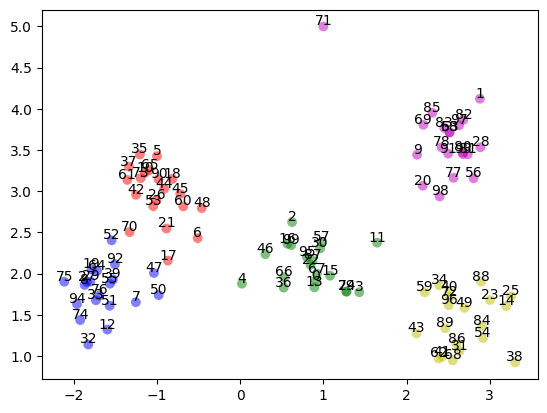

In [5]:
# Mapping from labels to colors
label_to_color = np.array(["b", "r", "g", "y", "m", "gray"])

# Translate labels to colors using vectorized operation
color_array = label_to_color[labels]

# Set plotting parameters
plot_kwds = {"alpha": 0.5, "s": 50, "linewidths": 0}

# Create scatter plot
plt.scatter(test_data.T[0], test_data.T[1], c=color_array, **plot_kwds)

# Annotate each point in the scatter plot
for i, (x, y) in enumerate(test_data):
    plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 1), ha="center")

In [6]:
# Verify the number of datapoints and that the shape is 2 dimensional
print("Number of samples: ", len(test_data))
print("Array shape:", test_data.ndim)

Number of samples:  100
Array shape: 2


In [7]:
# Evaluate the clusters
clusters = cluster(test_data, algorithm="hdbscan", n_clusters=5)

In [8]:
clusters["clusters"]

array([ 2,  0,  2,  2,  2,  3,  3,  4,  4,  0,  3,  2,  4,  2,  1,  2,  2,
        4,  3,  4,  0,  3,  2,  1,  2,  1,  3,  4,  0,  4,  2,  1,  4,  4,
        1,  3,  2,  3,  1,  4,  1,  1,  3,  1,  3,  3,  2,  4,  3,  1,  4,
        4,  4,  3,  1,  4,  0,  2,  0,  1,  3,  3,  1,  0,  4,  3,  2,  2,
        1,  0,  4, -1,  1,  3,  4,  4,  4,  0,  0,  2,  0,  0,  0,  0,  1,
        0,  1,  2,  1,  1,  3,  0,  4,  0,  4,  2,  1,  0,  0,  2])

In [9]:
### TEST ASSERTION CELL ###
assert clusters["clusters"].max() == 4
assert clusters["clusters"].min() == -1

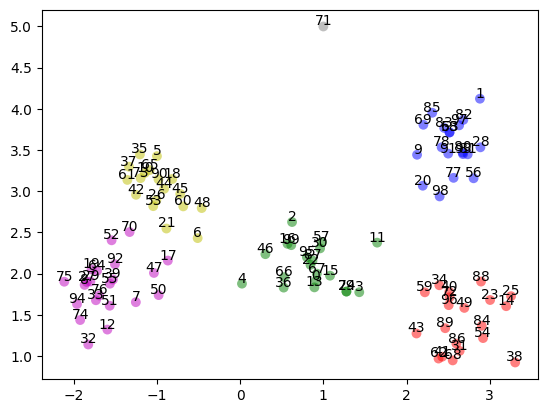

In [10]:
# Using the same plotting as above
color_array = label_to_color[clusters["clusters"]]
plt.scatter(test_data.T[0], test_data.T[1], c=color_array, **plot_kwds)

# Annotate each point in the scatter plot
for i, (x, y) in enumerate(test_data):
    plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 1), ha="center")

In [11]:
# Show results using the new detector classes
duplicates_detector = Duplicates()
duplicates_result = duplicates_detector.from_clusters(clusters)
print("exact image duplicates: ", duplicates_result.items.exact)
print("near image duplicates: ", duplicates_result.items.near)

outliers_detector = Outliers()
outliers_result = outliers_detector.from_clusters(test_data, clusters, threshold=3)
print("outliers: ", outliers_result.issues)

exact image duplicates:  [[24, 79], [58, 63]]
near image duplicates:  [[0, 13, 22, 67, 87, 95], [3, 24], [8, 27, 29], [10, 65], [16, 99], [17, 21], [19, 64], [30, 57], [31, 86], [33, 76], [36, 66], [39, 55], [40, 72, 96], [41, 62], [58, 83], [80, 81, 93], [82, 97]]
outliers:  shape: (1, 3)
┌─────────┬──────────────────┬──────────────┐
│ item_id ┆ metric_name      ┆ metric_value │
│ ---     ┆ ---              ┆ ---          │
│ i64     ┆ cat              ┆ f64          │
╞═════════╪══════════════════╪══════════════╡
│ 71      ┆ cluster_distance ┆ 4.000434     │
└─────────┴──────────────────┴──────────────┘


In [12]:
### TEST ASSERTION CELL ###
assert len(outliers_result.issues) == 1
assert duplicates_result.items.exact is not None
assert duplicates_result.items.near is not None
assert len(duplicates_result.items.exact) == 2
assert len(duplicates_result.items.near) == 17